# Python 実践データ分析 100本ノック 第2版

(Python Practical Data Analysis 100 Knocks, 2nd ed.)

### 第2部 実践編①：機械学習

(Part 2: Practice 1: Machine Learning)

### 第4章 顧客の行動を予測する10本ノック

 (Chapter 04: 10 knocks to predict customer behavior)

In [3]:
# Connect with Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
# Move to working folder
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/python-100knock-data-analytics/chap04/')

| No. | File Name | Outline |
|-----------|-----------|-----------|
|  1  | use_log.csv           | Historical gym usage data. Period April 2018 - March 2019.   |
|  2  | customer_master.csv   | Membership data as of the end of March 2019   |
|  3  | class_master.csv      | Membership classification data (all-time, daytime, etc.)   |
|  4  | campaign_master.csv   | Campaign category data (e.g., no admission fee)   |
|  5  | customer_join.csv     | Customer data including usage history created in Chapter 3   |

### knock 31 : Let's read and check the data.

In [38]:
import pandas as pd

In [42]:
uselog = pd.read_csv('use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [43]:
customer = pd.read_csv('customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

### knock 32 : Group your customers by clustering

In [44]:
customer_clustering = customer[["mean", "median","max", "min", "membership_period"]]
customer_clustering.head()

mean  median  max  min  membership_period
0  4.833333     5.0    8    2                 47
1  5.083333     5.0    7    3                 47
2  4.583333     5.0    6    3                 47
3  4.833333     4.5    7    2                 47
4  3.916667     4.0    6    1                 47

In [45]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [46]:
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering = customer_clustering.assign(cluster = clusters.labels_)

print(customer_clustering["cluster"].unique())
customer_clustering.head()

[2 1 0 3]


mean  median  max  min  membership_period  cluster
0  4.833333     5.0    8    2                 47        2
1  5.083333     5.0    7    3                 47        2
2  4.583333     5.0    6    3                 47        2
3  4.833333     4.5    7    2                 47        2
4  3.916667     4.0    6    1                 47        2

### knock 33 : Let's analyze the clustering results.

In [47]:
customer_clustering.columns = ["月内平均値","月内中央値", "月内最大値", "月内最小値","会員期間", "cluster"]
customer_clustering.groupby("cluster").count()

月内平均値  月内中央値  月内最大値  月内最小値  会員期間
cluster                                  
0         1334   1334   1334   1334  1334
1          771    771    771    771   771
2         1249   1249   1249   1249  1249
3          838    838    838    838   838

In [48]:
customer_clustering.groupby("cluster").mean()

月内平均値     月内中央値      月内最大値     月内最小値       会員期間
cluster                                                    
0        5.541974  5.392804   8.757871  2.704648  14.857571
1        3.065504  2.900130   4.783398  1.649805   9.276265
2        4.677561  4.670937   7.233787  2.153723  36.915933
3        8.064079  8.050716  10.014320  6.180191   7.016706

### knock 34 : Let's visualize the clustering results.

In [12]:
from sklearn.decomposition import PCA

In [49]:
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

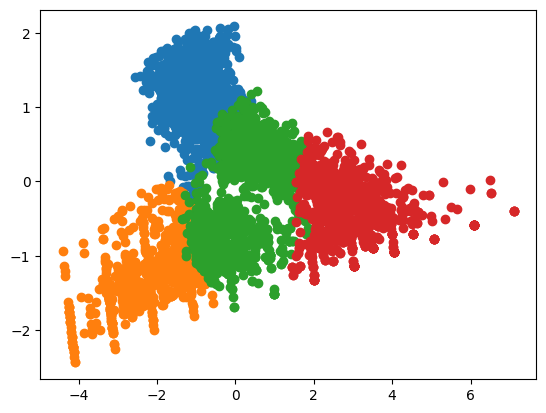

In [51]:
for i in customer_clustering["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"]==i]
    plt.scatter(tmp[0], tmp[1])

The results are neatly color-coded, showing that the reduction came in a clean way, leaving the information intact.

### knock 35 : Use clustering results to identify trends in exiting customers!

In [52]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(["cluster","is_deleted"],as_index=False).count()[["cluster","is_deleted","customer_id"]]

cluster  is_deleted  customer_id
0        0           0          791
1        0           1          543
2        1           1          771
3        2           0         1231
4        2           1           18
5        3           0          820
6        3           1           18

In [53]:
customer_clustering.groupby(["cluster","routine_flg"],as_index=False).count()[["cluster","routine_flg","customer_id"]]

cluster  routine_flg  customer_id
0        0            0          227
1        0            1         1107
2        1            0          499
3        1            1          272
4        2            0            2
5        2            1         1247
6        3            0           51
7        3            1          787

### knock 36 : Be prepared to forecast the number of times your customers will use the system in the following month!

In [54]:
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["年月"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["年月","customer_id"],as_index=False).count()
uselog_months.rename(columns={"log_id":"count"}, inplace=True)
del uselog_months["usedate"]
uselog_months.head()

年月 customer_id  count
0  201804    AS002855      4
1  201804    AS009013      2
2  201804    AS009373      3
3  201804    AS015315      6
4  201804    AS015739      7

In [55]:
year_months = list(uselog_months["年月"].unique())
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months["年月"]==year_months[i]].copy()
    tmp.rename(columns={"count":"count_pred"}, inplace=True)
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months["年月"]==year_months[i-j]].copy()
        del tmp_before["年月"]
        tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head()

年月 customer_id  count_pred  count_0  count_1  count_2  count_3  \
0  201810    AS002855           3      7.0      3.0      5.0      5.0   
1  201810    AS008805           2      2.0      5.0      7.0      8.0   
2  201810    AS009373           5      6.0      6.0      7.0      4.0   
3  201810    AS015233           7      9.0     11.0      5.0      7.0   
4  201810    AS015315           4      7.0      3.0      6.0      3.0   

   count_4  count_5  
0      5.0      4.0  
1      NaN      NaN  
2      4.0      3.0  
3      7.0      NaN  
4      3.0      6.0

In [56]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

年月 customer_id  count_pred  count_0  count_1  count_2  count_3  \
0  201810    AS002855           3      7.0      3.0      5.0      5.0   
1  201810    AS009373           5      6.0      6.0      7.0      4.0   
2  201810    AS015315           4      7.0      3.0      6.0      3.0   
3  201810    AS015739           5      6.0      5.0      8.0      6.0   
4  201810    AS019860           7      5.0      7.0      4.0      6.0   

   count_4  count_5  
0      5.0      4.0  
1      4.0      3.0  
2      3.0      6.0  
3      5.0      7.0  
4      8.0      6.0

### knock 37 : Let's add a variable that will be a feature.

In [57]:
predict_data = pd.merge(predict_data, customer[["customer_id","start_date"]], on="customer_id", how="left")
predict_data.head()

年月 customer_id  count_pred  count_0  count_1  count_2  count_3  \
0  201810    AS002855           3      7.0      3.0      5.0      5.0   
1  201810    AS009373           5      6.0      6.0      7.0      4.0   
2  201810    AS015315           4      7.0      3.0      6.0      3.0   
3  201810    AS015739           5      6.0      5.0      8.0      6.0   
4  201810    AS019860           7      5.0      7.0      4.0      6.0   

   count_4  count_5  start_date  
0      5.0      4.0  2016-11-01  
1      4.0      3.0  2015-11-01  
2      3.0      6.0  2015-07-01  
3      5.0      7.0  2017-06-01  
4      8.0      6.0  2017-10-01

In [58]:
predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])

In [59]:
from dateutil.relativedelta import relativedelta

In [60]:
predict_data["period"] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data.loc[i,"now_date"], predict_data.loc[i,"start_date"])
    predict_data.loc[i,"period"] = delta.years*12 + delta.months
predict_data.head()

年月 customer_id  count_pred  count_0  count_1  count_2  count_3  \
0  201810    AS002855           3      7.0      3.0      5.0      5.0   
1  201810    AS009373           5      6.0      6.0      7.0      4.0   
2  201810    AS015315           4      7.0      3.0      6.0      3.0   
3  201810    AS015739           5      6.0      5.0      8.0      6.0   
4  201810    AS019860           7      5.0      7.0      4.0      6.0   

   count_4  count_5 start_date   now_date period  
0      5.0      4.0 2016-11-01 2018-10-01     23  
1      4.0      3.0 2015-11-01 2018-10-01     35  
2      3.0      6.0 2015-07-01 2018-10-01     39  
3      5.0      7.0 2017-06-01 2018-10-01     16  
4      8.0      6.0 2017-10-01 2018-10-01     12

### knock 38 : Let's create a model to predict next month's usage frequency.

In [61]:
predict_data = predict_data.loc[predict_data["start_date"]>=pd.to_datetime("20180401")]

In [28]:
from sklearn import linear_model
import sklearn.model_selection

In [62]:
model = linear_model.LinearRegression()
X = predict_data[["count_0","count_1","count_2","count_3","count_4","count_5","period"]]
y = predict_data["count_pred"]
# Percentage of splits unspecified, data for training: 75%. Data for evaluation: 25%.
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, random_state=0)
model.fit(X_train, y_train)

LinearRegression()

In [63]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6111525903215709
0.5964633323568842


### knock 39 : Let's check the variables contributing to the model.

In [64]:
coef = pd.DataFrame({"feature_names":X.columns, "coefficient":model.coef_})
coef

feature_names  coefficient
0       count_0     0.359133
1       count_1     0.181937
2       count_2     0.151177
3       count_3     0.184593
4       count_4     0.076946
5       count_5     0.058731
6        period     0.047007

count_0 is the largest, and the contribution tends to be smaller the further back in time one goes.

In other words, it suggests that the most recent usage count has a significant impact on the next month's usage count.

### knock 40 : Let's predict the number of times you will use it next month.

Generate usage data for two customers.

The first is a customer who has come 7, 8, 6, 4, 4, 4, and 3 times per month for the previous 6 months, and the second is a customer who has come 6, 4, 3, 3, 3, 2, and 2 times per month, both with 8 months of enrollment, to predict the number of visits in the following month.

In [65]:
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = pd.DataFrame(data=[x1, x2],columns=["count_0","count_1","count_2","count_3","count_4","count_5","period"])

In [66]:
model.predict(x_pred)

array([3.77011036, 1.97563148])

The first and second customers were expected to come 3.8 and 1.9 times, respectively, in the following month.

In [67]:
uselog_months.to_csv("use_log_months.csv",index=False)